# Licences / Notes

In [1]:
# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#Adapted by Thierry Lincoln in November,2019 from this Colab notebook:
#https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb.
#Changes includes 

# - Reading our stressor data and parsing it properly
# - reconfiguring the last layer to include N neurons corresponding to N categories
# - correcting the probability output so that it follows [0,1] proper pattern 
# - better analysis with confusion matrix
# - exporting to pb format for tensorflow serving api

Intro:

If you’ve been following Natural Language Processing over the past year, you’ve probably heard of BERT: Bidirectional Encoder Representations from Transformers. It’s a neural network architecture designed by Google researchers that’s totally transformed what’s state-of-the-art for NLP tasks, like text classification, translation, summarization, and question answering.

Now that BERT's been added to [TF Hub](https://www.tensorflow.org/hub) as a loadable module, it's easy(ish) to add into existing Tensorflow text pipelines. In an existing pipeline, BERT can replace text embedding layers like ELMO and GloVE. Alternatively, [finetuning](http://wiki.fast.ai/index.php/Fine_tuning) BERT can provide both an accuracy boost and faster training time in many cases.

Some code was adapted from [this colab notebook](https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb). Let's get started!

# Loading Libraries

In [3]:
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib'
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #(or "1" or "2")

In [4]:
import sys
print(sys.executable)

/commuter/thierrylincoln/Tf1.1_py36/bin/python3.6


In [5]:
#export LD_LIBRARY_PATH=/usr/local/cuda-10.0/lib64:/usr/local/cuda-10.0/lib
#export CUDA_VISIBLE_DEVICES=0

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score,confusion_matrix,classification_report,accuracy_score


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

In [7]:
print(tf.__version__) #needs to be version 1.15.0, version 2.0 doesn't work with this notebook

1.15.0


In [8]:

config = tf.ConfigProto()
#config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1


#config.gpu_options.visible_device_list="0"


from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14674605915526922243, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17254112710229981599
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17007654484082868359
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11982965965
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15791138569670914687
 physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1"]

In addition to the standard libraries we imported above, we'll need to install BERT's python package.

In [9]:
#!pip install bert-tensorflow

In [10]:
import bert
from bert import run_classifier_with_tfhub
from bert import optimization
from bert import tokenization
import numpy as np


Below, we'll set an output directory location to store our model output and checkpoints. This can be a local directory, in which case you'd set OUTPUT_DIR to the name of the directory you'd like to create. 


Set DO_DELETE to rewrite the OUTPUT_DIR if it exists. Otherwise, Tensorflow will load existing model checkpoints from that directory (if they exist).

## Utils functions 

In [11]:
def f(x):
    n = 2  # index of the second proability to get labeled 

    index = np.argsort(x.values.flatten().tolist())[-n:][0]
    print(f"index is {index}")
    label  = label_list_text[index]
    print(f"label is {label}")
    
    return label
    

def manual_eval_metrics(df):
    df["SD"] = df[label_list_text].std(axis=1)
    df["SD-THRESHOLD"] = df[label_list_text].max(axis=1) - 2*df["SD"]
    df["Above SD-THRESHOLD"] = df.apply(lambda x: len(np.where(x[label_list_text]>x["SD-THRESHOLD"])[0]),axis=1)
    df["Branch"] = df.apply(lambda x: 1 if x["Above SD-THRESHOLD"]>1 else 0,axis=1)
    
    return df

final_columns = ["sOrder","Input.text","is_stressor","is_stressor_conf","top_label","second_label","Branch", "Above SD-THRESHOLD","SD-THRESHOLD","SD","Other","Everyday Decision Making","Work","Social Relationships","Financial Problem","Health, Fatigue, or Physical Pain","Emotional Turmoil","Family Issues","School","avg_severity","median_severity","SD_severity","Votes","Source"]

def get_test_experiment_df(test):
    test_predictions = [x[0]['probabilities'] for x in zip(getListPrediction(in_sentences=list(test[DATA_COLUMN])))]
    test_live_labels = np.array(test_predictions).argmax(axis=1)
    test[LABEL_COLUMN_RAW] = [label_list_text[x] for x in test_live_labels] # appending the labels to the dataframe
    
    probabilities_df_live = pd.DataFrame(test_predictions) # creating a proabilities dataset
    probabilities_df_live.columns = [x for x in label_list_text] # naming the columns
    probabilities_df_live['second_label'] = probabilities_df_live.apply(lambda x:f(x),axis=1)
    
    #print(test)
    #label_df = create_examples_prediction(test)
    #label_df.columns = label_list_text
    #label_df['label 2'] = label_df.apply(lambda x:f(x),axis=1)

    test.reset_index(inplace=True,drop=True) # resetting index 
    
    test_removed_columns =  list(set(test.columns)-set(probabilities_df_live.columns))
    
    test_temp = test[test_removed_columns]
    
    experiment_df = pd.concat([test_temp,probabilities_df_live],axis=1, ignore_index=False)
    
    
    missing_cols = list(set(experiment_df.columns)-set(final_columns))
    experiment_df[missing_cols] = np.nan#.loc[:, missing_cols] = np.nan
        
    experiment_df = experiment_df.reindex(columns = final_columns)
    experiment_df = manual_eval_metrics(experiment_df)
    
    #experiment_df = experiment_df.reindex(sorted(experiment_df.columns), axis=1)
    
    return test,experiment_df

In [12]:
def getListPrediction(in_sentences):
    #1
    input_examples = [bert.run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
    
    #2
    input_features = bert.run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
    
    #3
    predict_input_fn = bert.run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
    
    print(input_features[0].input_ids)
    #4
    predictions = estimator.predict(input_fn=predict_input_fn,yield_single_examples=True)
    
    return predictions

In [13]:
is_normalize_active=False

def get_confusion_matrix(y_test,predicted,labels):
    class_names=labels
    # plotting confusion matrix
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names,
                        title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, predicted, classes=class_names, normalize=True,
                        title='Normalized confusion matrix')
    plt.show()
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes =classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        test =1
        #print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax


# Loading the data

In [14]:
def data_prep_bert(df,test_size):
    
    print("Filling missing values")
    df[DATA_COLUMN] = df[DATA_COLUMN].fillna('_NA_')
    
    print("Splitting dataframe with shape {} into training and test datasets".format(df.shape))
    X_train, X_test  = train_test_split(df, test_size=test_size, random_state=2018,stratify = df[LABEL_COLUMN_RAW])

    return X_train, X_test


In [15]:
def open_dataset(NAME,mapping_index,excluded_categories):
    df = pd.read_csv(PATH+NAME+'.csv',sep =',')
    df.head(10)
    df = df[df[LABEL_COLUMN_RAW].notna()]
    
    
    
    #df.columns = [LABEL_COLUMN_RAW,'Severity',DATA_COLUMN,'Source']
    
    if excluded_categories is not None:
        for category in excluded_categories:

            df = df[df[LABEL_COLUMN_RAW] !=category]

    label_list=[]
    label_list_final =[]
    if(mapping_index is None):
        df[LABEL_COLUMN_RAW] = df[LABEL_COLUMN_RAW].astype('category')
        df[LABEL_COLUMN], mapping_index = pd.Series(df[LABEL_COLUMN_RAW]).factorize() #uses pandas factorize() to convert to numerical index
        
    else:
        df[LABEL_COLUMN] = df[LABEL_COLUMN_RAW].apply(lambda x: mapping_index.get_loc(x))
        
    label_list_final = [None] * len(mapping_index.categories)
    label_list_number = [None] * len(mapping_index.categories)

    for index,ele in enumerate(list(mapping_index.categories)):
        lindex = mapping_index.get_loc(ele)
        label_list_number[lindex] = lindex
        label_list_final[lindex] = ele

    frequency_dict = df[LABEL_COLUMN_RAW].value_counts().to_dict()
    df["class_freq"] = df[LABEL_COLUMN_RAW].apply(lambda x: frequency_dict[x])
    
    
    return df,mapping_index,label_list_number,label_list_final
    

# Require user changes > Start Here 

### Experiment Name

In [16]:
PATH = './datasets/'
TODAY_DATE = "31_07_2020/"
EXPERIMENT_NAME = 'ryukas_single_label_big_data'
EXPERIMENTS_PATH = PATH + 'experiments/'+TODAY_DATE+EXPERIMENT_NAME
if not os.path.exists(PATH + 'experiments/'+TODAY_DATE):
    os.mkdir(PATH + 'experiments/'+TODAY_DATE)
if not os.path.exists(EXPERIMENTS_PATH):
    os.mkdir(EXPERIMENTS_PATH)

### Model Hyperparameters

In [17]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 1000
SAVE_SUMMARY_STEPS = 100

# We'll set sequences to be at most 32 tokens long.
MAX_SEQ_LENGTH = 32


OUTPUT_DIR = './models/'+EXPERIMENT_NAME+ '/' #_01_04_2020/

In [18]:

DATASET_NAME = 'Filtered_df_everything'

DATA_COLUMN = 'Answer.Stressor'
LABEL_COLUMN_RAW = 'top_label'#'Answer.Label'
LABEL_COLUMN = 'label_numeric'



#dataset,mapping_index,label_list, label_list_text = open_dataset('mturk900balanced',None)

EXCLUDED_CATEGORIES = None #['Other'] #None # # if nothing to exclude put None, THIS ALWAYS MUST BE A LIST 
mapping_dict = {'Other': 0, 'Everyday Decision Making': 1, 'Work': 2, 'Social Relationships': 3, 'Financial Problem': 4, 'Emotional Turmoil': 5, 'Health, Fatigue, or Physical Pain': 6, 'School': 7, 'Family Issues': 8}#,'Not Stressful':9}
mapping_index = pd.CategoricalIndex([key for key,value in mapping_dict.items()])

dataset,mapping_index,label_list, label_list_text = open_dataset(DATASET_NAME,mapping_index,EXCLUDED_CATEGORIES)


test_on_mturk_and_popbots_live = True # include live data in training + include mturk in testing


if test_on_mturk_and_popbots_live:
    
    mturk = dataset[dataset['Source']== 'mTurk']
    live = dataset[dataset['Source']== 'Popbots']
    live = live.sample(frac=1).reset_index(drop=True) # shuffle live
    
    TEST_PERCENTAGE = len(live)/(2*len(mturk))  # given to set the percentage of mturk used as test set to have 50/50
    
    print(f"Test percentage is {TEST_PERCENTAGE}")

    train,test = data_prep_bert(mturk,TEST_PERCENTAGE) # test size from mturk 
    
    train = train.append(live.loc[0:int(len(live)/2)]) # taking 1/2 of that dataset for training
    test = test.append(live.loc[int(len(live)/2):int(len(live))]) # taking 1/2 of live dataset for testing
else:
    # or taking live only for testing
    train,test = dataset[dataset['Source']== 'mTurk'],dataset[dataset['Source']== 'Popbots'] 

#train,test = data_prep_bert(dataset,0.2)
#print(f"Dataset has {len(dataset)} training examples")
print(f"Normal label list is {label_list}")
print(f"The labels text is {label_list_text}")
print(f"test size is{len(test)}")
print(f"train size is{len(train)}")

#Export train test to csv
#train.to_csv(PATH+'900_CSV_SPLITTED/train.csv')
#test.to_csv(PATH+'900_CSV_SPLITTED/test.csv')

ZeroDivisionError: division by zero

In [19]:

DATA_COLUMN = 'Input.text'
LABEL_COLUMN_RAW = 'top_label'#'Answer.Label'
LABEL_COLUMN = 'label_numeric'

MTURK_NAME = 'mTurk_synthetic'
LIVE_NAME = 'popbots_live'
INQUIRE_NAME = 'Inquire'
MTURK_COVID_NAME = 'mTurk_synthetic_covid'

LABEL_HOT_VECTOR = 'label_conf'

#train.to_csv(EXPERIMENTS_PATH+'/TRAIN_'+DATASET_NAME+'.csv')
#test.to_csv(EXPERIMENTS_PATH+'/TEST_'+DATASET_NAME+'.csv')

#train = pd.read_csv('./datasets/experiments/29_07_2020/ryukas_evaluation/TRAIN_2020-07-27-MainTurkAggregation-5-Turkers_v0.csv')
test = pd.read_csv('./datasets/experiments/29_07_2020/ryukas_evaluation/TEST_2020-07-27-MainTurkAggregation-5-Turkers_v0.csv')

#test_down.to_csv(EXPERIMENTS_PATH+'/SMALL_TEST_'+DATASET_NAME+'.csv')
test_down = pd.read_csv('./datasets/experiments/29_07_2020/ryukas_evaluation/SMALL_TEST_2020-07-27-MainTurkAggregation-5-Turkers_v0.csv')
train = pd.read_csv('./datasets/experiments/29_07_2020/ryukas_evaluation/SMALL_TRAIN_2020-07-27-MainTurkAggregation-5-Turkers_v0.csv')

In [20]:
train = train.sample(frac=1).reset_index(drop=True) #reshuffle everything
test = test.sample(frac=1).reset_index(drop=True)

### Train set and test set analysis

In [21]:
def print_dataset_info(train,test):
    print(f"Train size {len(train)} with {len(train[train['Source']== 'Popbots'])} from Popbots and {len(train[train['Source']== 'mTurk'])} from mturk")
    print(f"Test size {len(test)} with {len(test[test['Source']== 'Popbots'])} from Popbots and {len(test[test['Source']== 'mTurk'])} from mturk")
    
    print('\nTraining distribution:')
    print(pd.pivot_table(train[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)
          
    print('\nTesting distribution:')
    print(pd.pivot_table(test[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=True)

In [22]:
train = train.sample(frac=1).reset_index(drop=True) #reshuffle everything
test = test.sample(frac=1).reset_index(drop=True)

In [23]:
print('\nAll dataset distribution:')
print(pd.pivot_table(dataset[[LABEL_COLUMN_RAW, 'Source']],index=[LABEL_COLUMN_RAW, 'Source'],columns=None, aggfunc=len)) #.to_clipboard(excel=T


All dataset distribution:
top_label                          Source                 
Emotional Turmoil                  Inquire                    379
                                   InquireComposited          106
                                   mTurk_synthetic_covid       19
                                   mTurk_synthetic_covid_2     10
Everyday Decision Making           Inquire                    132
                                   InquireComposited           60
                                   mTurk_synthetic              6
                                   mTurk_synthetic_covid       17
                                   mTurk_synthetic_covid_2      5
Family Issues                      Inquire                    406
                                   InquireComposited           28
                                   mTurk_synthetic            148
                                   mTurk_synthetic_covid       35
                                   mTurk_synthetic_covid

In [174]:
print_dataset_info(train,test)

Train size 2014 with 93 from Popbots and 1921 from mturk
Test size 186 with 93 from Popbots and 93 from mturk

Training distribution:
Consolidated Updated Categories  Source 
Emotional Turmoil                Popbots      2
                                 mTurk      206
Everyday Decision Making         mTurk       59
Family Issues                    Popbots      4
                                 mTurk      232
Financial Problem                Popbots      4
                                 mTurk      393
Health or Physical Pain          Popbots     15
                                 mTurk      141
Other                            Popbots     18
                                 mTurk       96
School                           Popbots      9
                                 mTurk      131
Social Relationships             Popbots     12
                                 mTurk       34
Work                             Popbots     29
                                 mTurk      629
dtype: in

### Step to reduce the most dominant categories and balance the dataset

In [175]:
sampling_cutoff = 100 # all the categories which had less than 100 example won't be sampled down
total_training_size = 1501

REVERSE_FREQ = 'Max_reverse_sampling_chance'
train[REVERSE_FREQ] = train['class_freq'].apply(lambda x: (max(train['class_freq'])/x)*(max(train['class_freq'])/x)) 

sampling_boolean = (train['Source'] != 'Popbots') & (train['class_freq'].astype(float) > sampling_cutoff) 


train_to_be_balanced = train[sampling_boolean]
train_not_resampled = train[~sampling_boolean]

train_temp = train_to_be_balanced.sample(n=(total_training_size-len(train_not_resampled)), weights=REVERSE_FREQ, random_state=2020)
train = pd.concat([train_temp,train_not_resampled])

In [176]:
print_dataset_info(train,test)

Train size 1501 with 93 from Popbots and 1408 from mturk
Test size 186 with 93 from Popbots and 93 from mturk

Training distribution:
Consolidated Updated Categories  Source 
Emotional Turmoil                Popbots      2
                                 mTurk      203
Everyday Decision Making         mTurk       59
Family Issues                    Popbots      4
                                 mTurk      224
Financial Problem                Popbots      4
                                 mTurk      296
Health or Physical Pain          Popbots     15
                                 mTurk      141
Other                            Popbots     18
                                 mTurk       96
School                           Popbots      9
                                 mTurk      131
Social Relationships             Popbots     12
                                 mTurk       34
Work                             Popbots     29
                                 mTurk      224
dtype: in

In [177]:
mapping_index.categories

Index(['Emotional Turmoil', 'Everyday Decision Making', 'Family Issues',
       'Financial Problem', 'Health or Physical Pain', 'Other', 'School',
       'Social Relationships', 'Work'],
      dtype='object')

In [178]:
train.to_csv(EXPERIMENTS_PATH+'/TRAIN_'+DATASET_NAME+'.csv')
test.to_csv(EXPERIMENTS_PATH+'/TEST_'+DATASET_NAME+'.csv')

# Require user changes > STOP Here 

# Data Preprocessing

For us, our input data is the 'sentence' column and our label is the 'polarity' column 

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [24]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was 

1.   List item
2.   List item

trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




To start, we'll need to load a vocabulary file and lowercasing information directly from the BERT tf hub module:

In [25]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Great--we just learned that the BERT model we're using expects lowercase data (that's what stored in tokenization_info["do_lower_case"]) and we also loaded BERT's vocab file. We also created a tokenizer, which breaks words into word pieces:

In [26]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

Using our tokenizer, we'll call `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands.

In [27]:

# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 564


INFO:tensorflow:Writing example 0 of 564


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] wow , it seems almost every day i find yet another reason to absolutely lo ##ath ##e my current residence . [SEP]


INFO:tensorflow:tokens: [CLS] wow , it seems almost every day i find yet another reason to absolutely lo ##ath ##e my current residence . [SEP]


INFO:tensorflow:input_ids: 101 10166 1010 2009 3849 2471 2296 2154 1045 2424 2664 2178 3114 2000 7078 8840 8988 2063 2026 2783 5039 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 10166 1010 2009 3849 2471 2296 2154 1045 2424 2664 2178 3114 2000 7078 8840 8988 2063 2026 2783 5039 1012 102 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] financial uncertainty and the stress it creates . [SEP]


INFO:tensorflow:tokens: [CLS] financial uncertainty and the stress it creates . [SEP]


INFO:tensorflow:input_ids: 101 3361 12503 1998 1996 6911 2009 9005 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3361 12503 1998 1996 6911 2009 9005 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] hence , we are pretty much financially broke . [SEP]


INFO:tensorflow:tokens: [CLS] hence , we are pretty much financially broke . [SEP]


INFO:tensorflow:input_ids: 101 6516 1010 2057 2024 3492 2172 13732 3631 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6516 1010 2057 2024 3492 2172 13732 3631 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] h ##yp ##och ##ond ##ria ##c : : i don ' t feel so good right now . . . ins ##ecure : : when i ' m having an [SEP]


INFO:tensorflow:tokens: [CLS] h ##yp ##och ##ond ##ria ##c : : i don ' t feel so good right now . . . ins ##ecure : : when i ' m having an [SEP]


INFO:tensorflow:input_ids: 101 1044 22571 11663 15422 4360 2278 1024 1024 1045 2123 1005 1056 2514 2061 2204 2157 2085 1012 1012 1012 16021 29150 1024 1024 2043 1045 1005 1049 2383 2019 102


INFO:tensorflow:input_ids: 101 1044 22571 11663 15422 4360 2278 1024 1024 1045 2123 1005 1056 2514 2061 2204 2157 2085 1012 1012 1012 16021 29150 1024 1024 2043 1045 1005 1049 2383 2019 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] charles whitman told his doctor that he was feeling " low " after his parents ' divorce and hadn ' t been feeling well . [SEP]


INFO:tensorflow:tokens: [CLS] charles whitman told his doctor that he was feeling " low " after his parents ' divorce and hadn ' t been feeling well . [SEP]


INFO:tensorflow:input_ids: 101 2798 21311 2409 2010 3460 2008 2002 2001 3110 1000 2659 1000 2044 2010 3008 1005 8179 1998 2910 1005 1056 2042 3110 2092 1012 102 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2798 21311 2409 2010 3460 2008 2002 2001 3110 1000 2659 1000 2044 2010 3008 1005 8179 1998 2910 1005 1056 2042 3110 2092 1012 102 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:Writing example 0 of 822


INFO:tensorflow:Writing example 0 of 822


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i got really scared be ##cas ##ue this happened on the way home . [SEP]


INFO:tensorflow:tokens: [CLS] i got really scared be ##cas ##ue this happened on the way home . [SEP]


INFO:tensorflow:input_ids: 101 1045 2288 2428 6015 2022 15671 5657 2023 3047 2006 1996 2126 2188 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2288 2428 6015 2022 15671 5657 2023 3047 2006 1996 2126 2188 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] see what happens when i get stressed out . [SEP]


INFO:tensorflow:tokens: [CLS] see what happens when i get stressed out . [SEP]


INFO:tensorflow:input_ids: 101 2156 2054 6433 2043 1045 2131 13233 2041 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2156 2054 6433 2043 1045 2131 13233 2041 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:label: 5 (id = 5)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i miss her a lot now that i don ##t see her very often , and it makes me kind of sad . [SEP]


INFO:tensorflow:tokens: [CLS] i miss her a lot now that i don ##t see her very often , and it makes me kind of sad . [SEP]


INFO:tensorflow:input_ids: 101 1045 3335 2014 1037 2843 2085 2008 1045 2123 2102 2156 2014 2200 2411 1010 1998 2009 3084 2033 2785 1997 6517 1012 102 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 3335 2014 1037 2843 2085 2008 1045 2123 2102 2156 2014 2200 2411 1010 1998 2009 3084 2033 2785 1997 6517 1012 102 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i had a lot of trouble getting to sleep , despite my being extremely tired . [SEP]


INFO:tensorflow:tokens: [CLS] i had a lot of trouble getting to sleep , despite my being extremely tired . [SEP]


INFO:tensorflow:input_ids: 101 1045 2018 1037 2843 1997 4390 2893 2000 3637 1010 2750 2026 2108 5186 5458 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2018 1037 2843 1997 4390 2893 2000 3637 1010 2750 2026 2108 5186 5458 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:label: 6 (id = 6)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] deadline ##s [SEP]


INFO:tensorflow:tokens: [CLS] deadline ##s [SEP]


INFO:tensorflow:input_ids: 101 15117 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 15117 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 2 (id = 2)


INFO:tensorflow:label: 2 (id = 2)


# Creating a model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our classification task. This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

To understand the `pooled ouput` vs `sequence output` refer to https://www.kaggle.com/questions-and-answers/86510

In [28]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True) # fined tuning the complete weights of all the model
    
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"] # 768 dimention vector

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
    
    # does the Ax multiplication
    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    # add the bias eg: Ax+B
    logits = tf.nn.bias_add(logits, output_bias)
    
    
    ########################### HERE ADDITIONAL LAYERS CAN BE ADDED ######################
    
    # compute the log softmax for each neurons/logit
    #log_probs = tf.nn.log_softmax(logits, axis=-1)
    
    #compute the normal softmax to get the probabilities
    #probs = tf.nn.softmax(logits, axis=-1)
    
    # Convert labels into one-hot encoding 
    #one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
    
    #classes_weights = tf.constant([1.0,1.0,1.0,1.0,1.0,1.0,0.7], dtype=tf.float32)
    #sample_weights = tf.multiply(one_hot_labels, classes_weights)

    # probabilities = tf.nn.softmax(logits, axis=-1) ### multiclass case
    probabilities = tf.nn.sigmoid(logits)#### multi-label case

    #labels = tf.cast(labels, tf.float32)
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    #tf.logging.info("num_labels:{};logits:{};labels:{}".format(num_labels, logits, labels))
    per_example_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=one_hot_labels, logits=logits)
    loss = tf.reduce_mean(per_example_loss)
    
    
    
    #predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    predicted_labels = tf.squeeze(tf.argmax(probabilities, axis=-1, output_type=tf.int32))

    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, probabilities,probabilities)#log_probs,probs)

    # If we're train/eval, compute loss between predicted and actual label
    #per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    #per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    
    #loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, probabilities)#log_probs)


Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [29]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        """
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)"""
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        
        return {
            "eval_accuracy": accuracy,
            #"f1_score": f1_score,
            #"auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs,probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': probs#,
          #'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [30]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [31]:
# Specify outpit directory and number of checkpoint steps to save

run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [32]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': './models/ryukas_single_label_big_data/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde1864c748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': './models/ryukas_single_label_big_data/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde1864c748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [33]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Training the model

In [34]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/commuter/thierrylincoln/Tf1.1_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ./models/ryukas_single_label_big_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into ./models/ryukas_single_label_big_data/model.ckpt.


INFO:tensorflow:loss = 0.7110636, step = 0


INFO:tensorflow:loss = 0.7110636, step = 0


INFO:tensorflow:global_step/sec: 3.58126


INFO:tensorflow:global_step/sec: 3.58126


INFO:tensorflow:loss = 0.20708829, step = 100 (27.924 sec)


INFO:tensorflow:loss = 0.20708829, step = 100 (27.924 sec)


INFO:tensorflow:Saving checkpoints for 105 into ./models/ryukas_single_label_big_data/model.ckpt.


INFO:tensorflow:Saving checkpoints for 105 into ./models/ryukas_single_label_big_data/model.ckpt.


INFO:tensorflow:Loss for final step: 0.19923112.


INFO:tensorflow:Loss for final step: 0.19923112.


Training took time  0:01:22.023882


# Evaluating the model on Test Set

In [35]:
test_input_fn = bert.run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [36]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/commuter/thierrylincoln/Tf1.1_py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-08-03T07:32:37Z


INFO:tensorflow:Starting evaluation at 2020-08-03T07:32:37Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_big_data/model.ckpt-105


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_big_data/model.ckpt-105


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2020-08-03-07:32:46


INFO:tensorflow:Finished evaluation at 2020-08-03-07:32:46


INFO:tensorflow:Saving dict for global step 105: eval_accuracy = 0.7141119, false_negatives = 25.0, false_positives = 61.0, global_step = 105, loss = 0.222553, precision = 0.9198423, recall = 0.9655172, true_negatives = 36.0, true_positives = 700.0


INFO:tensorflow:Saving dict for global step 105: eval_accuracy = 0.7141119, false_negatives = 25.0, false_positives = 61.0, global_step = 105, loss = 0.222553, precision = 0.9198423, recall = 0.9655172, true_negatives = 36.0, true_positives = 700.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 105: ./models/ryukas_single_label_big_data/model.ckpt-105


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 105: ./models/ryukas_single_label_big_data/model.ckpt-105


{'eval_accuracy': 0.7141119,
 'false_negatives': 25.0,
 'false_positives': 61.0,
 'loss': 0.222553,
 'precision': 0.9198423,
 'recall': 0.9655172,
 'true_negatives': 36.0,
 'true_positives': 700.0,
 'global_step': 105}

In [37]:
#fetching all the probabilities for each line of the test set
test_probabilities = [x[0]['probabilities'] for x in zip(estimator.predict(test_input_fn,yield_single_examples=True))]

#taking the argmex for the highest category
test_final_labels = np.array(test_probabilities).argmax(axis=1)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_big_data/model.ckpt-105


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_big_data/model.ckpt-105


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


### Classification Report

In [43]:
def replace_by_multi_hot(array, threshold):

    two_std = threshold*np.std(array)

    array = [1 if x > two_std else 0 for x in array]
    
    return array



y_true = pd.DataFrame(test[label_list_text]).apply(lambda x: replace_by_multi_hot(x,1),axis=1).to_list()
y_pred = pd.DataFrame(test_probabilities).apply(lambda x: replace_by_multi_hot(x,1),axis=1).to_list()

from sklearn.metrics import hamming_loss, accuracy_score , f1_score

print("accuracy_score:", accuracy_score(y_true, y_pred)) # exact match
print("f1_score:", f1_score(y_true, y_pred, average='weighted'))

print("Hamming_loss:", hamming_loss(y_true, y_pred))

print("Exact match:",np.all(np.array(y_pred) == np.array(y_true), axis=1).mean())

print("Hamming_score:", (np.array(y_pred) == np.array(y_true)).mean())


accuracy_score: 0.20924574209245742
f1_score: 0.5018608903647868
Hamming_loss: 0.3396864017301974
Exact match: 0.20924574209245742
Hamming_score: 0.6603135982698026


In [49]:
for i in np.arange(0.5, 4, 0.1):
    
    y_true = pd.DataFrame(test[label_list_text]).apply(lambda x: replace_by_multi_hot(x,i),axis=1).to_list()
    y_pred = pd.DataFrame(test_probabilities).apply(lambda x: replace_by_multi_hot(x,i),axis=1).to_list()
    
    print(f"For {i:.2f} std, hamming lost of {hamming_loss(y_true, y_pred):.2f} weighted f1 of {f1_score(y_true, y_pred, average='weighted'):.2f} accuracy of {accuracy_score(y_true, y_pred):.2f}")

For 0.50 std, hamming lost of 0.54 weighted f1 of 0.48 accuracy of 0.04
For 0.60 std, hamming lost of 0.50 weighted f1 of 0.47 accuracy of 0.07
For 0.70 std, hamming lost of 0.45 weighted f1 of 0.47 accuracy of 0.09
For 0.80 std, hamming lost of 0.41 weighted f1 of 0.47 accuracy of 0.12
For 0.90 std, hamming lost of 0.37 weighted f1 of 0.49 accuracy of 0.15
For 1.00 std, hamming lost of 0.34 weighted f1 of 0.50 accuracy of 0.21
For 1.10 std, hamming lost of 0.31 weighted f1 of 0.50 accuracy of 0.26
For 1.20 std, hamming lost of 0.29 weighted f1 of 0.51 accuracy of 0.28
For 1.30 std, hamming lost of 0.26 weighted f1 of 0.52 accuracy of 0.31
For 1.40 std, hamming lost of 0.24 weighted f1 of 0.53 accuracy of 0.34
For 1.50 std, hamming lost of 0.22 weighted f1 of 0.54 accuracy of 0.37
For 1.60 std, hamming lost of 0.20 weighted f1 of 0.54 accuracy of 0.41
For 1.70 std, hamming lost of 0.19 weighted f1 of 0.56 accuracy of 0.43
For 1.80 std, hamming lost of 0.17 weighted f1 of 0.57 accuracy 

In [40]:
report = pd.DataFrame(classification_report(list(test[LABEL_COLUMN]),list(test_final_labels),zero_division=0, output_dict=True)).T

print(report)

              precision    recall  f1-score     support
0              0.571429  0.371134  0.450000   97.000000
1              0.000000  0.000000  0.000000   35.000000
2              0.750973  0.979695  0.850220  197.000000
3              0.724638  0.675676  0.699301   74.000000
4              0.850746  0.802817  0.826087   71.000000
5              0.690476  0.371795  0.483333   78.000000
6              0.553719  0.807229  0.656863   83.000000
7              0.903226  0.923077  0.913043   91.000000
8              0.681818  0.781250  0.728155   96.000000
accuracy       0.718978  0.718978  0.718978    0.718978
macro avg      0.636336  0.634741  0.623000  822.000000
weighted avg   0.687178  0.718978  0.689481  822.000000


/commuter/thierrylincoln/Tf1.1_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

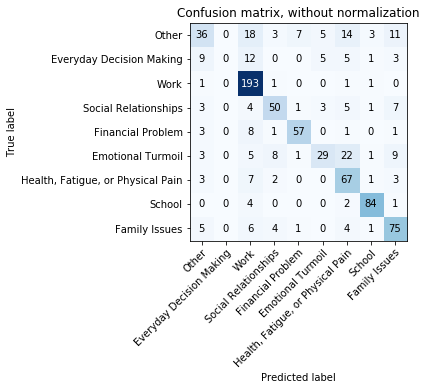

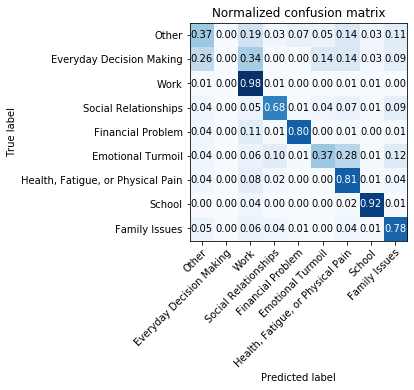

In [41]:
get_confusion_matrix(y_test=test[LABEL_COLUMN],predicted=test_final_labels,labels=label_list_text)

### Exporting test set with probabilities

In [58]:
test, experiment_df = get_test_experiment_df(test)
experiment_df.to_csv(EXPERIMENTS_PATH+'/test_with_probabilities.csv') 

test_down, experiment_df = get_test_experiment_df(test_down)
experiment_df.to_csv(EXPERIMENTS_PATH+'/testdown_with_probabilities.csv') 

INFO:tensorflow:Writing example 0 of 822


INFO:tensorflow:Writing example 0 of 822


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] feeling inadequate at work / doubt ##ing what occupation fits for me [SEP]


INFO:tensorflow:tokens: [CLS] feeling inadequate at work / doubt ##ing what occupation fits for me [SEP]


INFO:tensorflow:input_ids: 101 3110 14710 2012 2147 1013 4797 2075 2054 6139 16142 2005 2033 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 3110 14710 2012 2147 1013 4797 2075 2054 6139 16142 2005 2033 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] stress has made me irrational . [SEP]


INFO:tensorflow:tokens: [CLS] stress has made me irrational . [SEP]


INFO:tensorflow:input_ids: 101 6911 2038 2081 2033 23179 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 6911 2038 2081 2033 23179 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] my temper is going to get out of control one day with these doctors , and its going to be bad . [SEP]


INFO:tensorflow:tokens: [CLS] my temper is going to get out of control one day with these doctors , and its going to be bad . [SEP]


INFO:tensorflow:input_ids: 101 2026 12178 2003 2183 2000 2131 2041 1997 2491 2028 2154 2007 2122 7435 1010 1998 2049 2183 2000 2022 2919 1012 102 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 12178 2003 2183 2000 2131 2041 1997 2491 2028 2154 2007 2122 7435 1010 1998 2049 2183 2000 2022 2919 1012 102 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] life is tough these days and we ' re all forced to be more serious than we should . [SEP]


INFO:tensorflow:tokens: [CLS] life is tough these days and we ' re all forced to be more serious than we should . [SEP]


INFO:tensorflow:input_ids: 101 2166 2003 7823 2122 2420 1998 2057 1005 2128 2035 3140 2000 2022 2062 3809 2084 2057 2323 1012 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2166 2003 7823 2122 2420 1998 2057 1005 2128 2035 3140 2000 2022 2062 3809 2084 2057 2323 1012 102 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] it ' s been a rough week at work ! [SEP]


INFO:tensorflow:tokens: [CLS] it ' s been a rough week at work ! [SEP]


INFO:tensorflow:input_ids: 101 2009 1005 1055 2042 1037 5931 2733 2012 2147 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2009 1005 1055 2042 1037 5931 2733 2012 2147 999 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


[101, 3110, 14710, 2012, 2147, 1013, 4797, 2075, 2054, 6139, 16142, 2005, 2033, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_small_data/model.ckpt-105


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_small_data/model.ckpt-105


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


index is 4
label is Financial Problem
index is 5
label is Emotional Turmoil
index is 5
label is Emotional Turmoil
index is 8
label is Family Issues
index is 4
label is Financial Problem
index is 7
label is School
index is 6
label is Health, Fatigue, or Physical Pain
index is 7
label is School
index is 3
label is Social Relationships
index is 6
label is Health, Fatigue, or Physical Pain
index is 7
label is School
index is 2
label is Work
index is 3
label is Social Relationships
index is 8
label is Family Issues
index is 0
label is Other
index is 2
label is Work
index is 4
label is Financial Problem
index is 5
label is Emotional Turmoil
index is 2
label is Work
index is 2
label is Work
index is 2
label is Work
index is 5
label is Emotional Turmoil
index is 0
label is Other
index is 3
label is Social Relationships
index is 8
label is Family Issues
index is 3
label is Social Relationships
index is 2
label is Work
index is 6
label is Health, Fatigue, or Physical Pain
index is 6
label is Hea

index is 3
label is Social Relationships
index is 2
label is Work
index is 7
label is School
index is 2
label is Work
index is 4
label is Financial Problem
index is 7
label is School
index is 0
label is Other
index is 4
label is Financial Problem
index is 5
label is Emotional Turmoil
index is 2
label is Work
INFO:tensorflow:Writing example 0 of 102


INFO:tensorflow:Writing example 0 of 102


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] a stress ##ful aspect to this all is that i have to finish my week out there . [SEP]


INFO:tensorflow:tokens: [CLS] a stress ##ful aspect to this all is that i have to finish my week out there . [SEP]


INFO:tensorflow:input_ids: 101 1037 6911 3993 7814 2000 2023 2035 2003 2008 1045 2031 2000 3926 2026 2733 2041 2045 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1037 6911 3993 7814 2000 2023 2035 2003 2008 1045 2031 2000 3926 2026 2733 2041 2045 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] my girlfriend broke up with me around 3 days ago , i can ' t handle how much pain she put me through . [SEP]


INFO:tensorflow:tokens: [CLS] my girlfriend broke up with me around 3 days ago , i can ' t handle how much pain she put me through . [SEP]


INFO:tensorflow:input_ids: 101 2026 6513 3631 2039 2007 2033 2105 1017 2420 3283 1010 1045 2064 1005 1056 5047 2129 2172 3255 2016 2404 2033 2083 1012 102 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2026 6513 3631 2039 2007 2033 2105 1017 2420 3283 1010 1045 2064 1005 1056 5047 2129 2172 3255 2016 2404 2033 2083 1012 102 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i ' ve been upset over that . . . my life is literally . . . . [SEP]


INFO:tensorflow:tokens: [CLS] i ' ve been upset over that . . . my life is literally . . . . [SEP]


INFO:tensorflow:input_ids: 101 1045 1005 2310 2042 6314 2058 2008 1012 1012 1012 2026 2166 2003 6719 1012 1012 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1005 2310 2042 6314 2058 2008 1012 1012 1012 2026 2166 2003 6719 1012 1012 1012 1012 102 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] don ' t you hate it when you are stressed out , but you know that some of what you ' re stress ##ing about is your own fault ? [SEP]


INFO:tensorflow:tokens: [CLS] don ' t you hate it when you are stressed out , but you know that some of what you ' re stress ##ing about is your own fault ? [SEP]


INFO:tensorflow:input_ids: 101 2123 1005 1056 2017 5223 2009 2043 2017 2024 13233 2041 1010 2021 2017 2113 2008 2070 1997 2054 2017 1005 2128 6911 2075 2055 2003 2115 2219 6346 1029 102


INFO:tensorflow:input_ids: 101 2123 1005 1056 2017 5223 2009 2043 2017 2024 13233 2041 1010 2021 2017 2113 2008 2070 1997 2054 2017 1005 2128 6911 2075 2055 2003 2115 2219 6346 1029 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] i have been feeling really bad about the way that things have been going on lately . [SEP]


INFO:tensorflow:tokens: [CLS] i have been feeling really bad about the way that things have been going on lately . [SEP]


INFO:tensorflow:input_ids: 101 1045 2031 2042 3110 2428 2919 2055 1996 2126 2008 2477 2031 2042 2183 2006 9906 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2031 2042 3110 2428 2919 2055 1996 2126 2008 2477 2031 2042 2183 2006 9906 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


[101, 1037, 6911, 3993, 7814, 2000, 2023, 2035, 2003, 2008, 1045, 2031, 2000, 3926, 2026, 2733, 2041, 2045, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_small_data/model.ckpt-105


INFO:tensorflow:Restoring parameters from ./models/ryukas_single_label_small_data/model.ckpt-105


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


index is 6
label is Health, Fatigue, or Physical Pain
index is 8
label is Family Issues
index is 6
label is Health, Fatigue, or Physical Pain
index is 6
label is Health, Fatigue, or Physical Pain
index is 8
label is Family Issues
index is 0
label is Other
index is 5
label is Emotional Turmoil
index is 8
label is Family Issues
index is 8
label is Family Issues
index is 7
label is School
index is 3
label is Social Relationships
index is 5
label is Emotional Turmoil
index is 0
label is Other
index is 6
label is Health, Fatigue, or Physical Pain
index is 6
label is Health, Fatigue, or Physical Pain
index is 5
label is Emotional Turmoil
index is 5
label is Emotional Turmoil
index is 3
label is Social Relationships
index is 4
label is Financial Problem
index is 3
label is Social Relationships
index is 5
label is Emotional Turmoil
index is 3
label is Social Relationships
index is 3
label is Social Relationships
index is 6
label is Health, Fatigue, or Physical Pain
index is 3
label is Social R

In [197]:
experiment_df

,sID,Answer.Stressor,Source,Detailed Source,Old Categories,Updated Categories,Consolidated Updated Categories,Frequency,Max_reverse_sampling_chance,Answer.Severity,user ID,label_numeric,class_freq,Predicted,Work,Other,Family Issues,Emotional Turmoil,Financial Problem,Health or Physical Pain,School,Social Relationships,Everyday Decision Making
0,262,i am worried about how sick my daughter is.,mTurk,new_mturk_1020,Family Issues,Family Issues,Family Issues,252,8.117977,6,NaN,2,252,Family Issues,0.011062,0.023585,0.737777,0.103680,0.018506,0.070857,0.011799,0.010433,0.012300
1,2149,getting ebola.,Popbots,popbots_live,Health or Physical Pain,Health or Physical Pain,Health or Physical Pain,180,15.911235,3,NaN,5,180,Health or Physical Pain,0.016802,0.034319,0.029660,0.041637,0.032038,0.803796,0.011735,0.016240,0.013774
2,2101,too much work time not enough me time,Popbots,popbots_live,Work,Work,Work,718,1.000000,5,NaN,0,718,Work,0.779570,0.016918,0.012314,0.016792,0.018045,0.109091,0.012810,0.013540,0.020919
3,2142,nothing really - just wanted to say hello,Popbots,popbots_live,Other,Other,Other,140,26.302245,9,NaN,1,140,Other,0.059658,0.353048,0.047781,0.289871,0.054992,0.065264,0.040950,0.055641,0.032796
4,2063,nothing really,Popbots,popbots_live,Other,Other,Other,140,26.302245,9,NaN,1,140,Other,0.064395,0.349289,0.074770,0.204708,0.073586,0.120580,0.036330,0.046827,0.029515
5,1649,reports i need to finish at work,mTurk,old_mturk_1000,Work,Work,Work,718,1.000000,5,A2ZYO0FHHESP4J,0,718,Work,0.895937,0.013963,0.006886,0.007618,0.007746,0.013167,0.021049,0.012231,0.021404
6,886,"money problems, i have been having several unexpected bills recently.",mTurk,new_mturk_1020,Financial Problem,Financial Problem,Financial Problem,417,2.964673,5,NaN,4,417,Financial Problem,0.004111,0.004219,0.003593,0.007807,0.962415,0.008068,0.001962,0.004373,0.003453
7,1452,college and work have both been pretty stressful.,mTurk,old_mturk_1000,Work,Work,Work,718,1.000000,3,A33RCNCU6YTYD4,0,718,School,0.102421,0.025077,0.017987,0.030367,0.011694,0.008593,0.785044,0.007941,0.010876
8,2186,just a regular day,Popbots,popbots_live,Other,Other,Other,140,26.302245,9,NaN,1,140,Other,0.044240,0.292250,0.069412,0.253447,0.047126,0.197865,0.029564,0.033403,0.032693
9,2155,i am trying to interact with a person who at times is in a bad mood,Popbots,popbots_live,Social Relationship,Social Relationships,Social Relationships,60,143.201111,2,NaN,7,60,Emotional Turmoil,0.020460,0.074286,0.154215,0.615414,0.010749,0.031226,0.022159,0.042550,0.028941


### RUN ALL CELLS ABOVE ON HERE

In [151]:
experiment_df[experiment_df['Predicted'] != experiment_df['Answer.Label']].head(10) # change head(n) to see more  

KeyError: 'Answer.Label'

# Exporting the model as Pb format

In [41]:
def export_model(dir_path):
    MAX_SEQ_LEN = 128
    def serving_input_receiver_fn():
        """An input receiver that expects a serialized tf.Example."""
        reciever_tensors = {
            "input_ids": tf.placeholder(dtype=tf.int32,
                                        shape=[1, MAX_SEQ_LEN])
        }
        features = {
            "label_ids":tf.placeholder(tf.int32, [None], name='label_ids'),
            "input_ids": reciever_tensors['input_ids'],
            "input_mask": 1 - tf.cast(tf.equal(reciever_tensors['input_ids'], 0), dtype=tf.int32),
            "segment_ids": tf.zeros(dtype=tf.int32,
                                    shape=[1, MAX_SEQ_LEN])
            
        }
        return tf.estimator.export.ServingInputReceiver(features, reciever_tensors)

    estimator._export_to_tpu = False
    estimator.export_saved_model(dir_path, serving_input_receiver_fn)

In [114]:
export_model('./tfmode/pbformat/')

NameError: name 'export_model' is not defined

## Getting analysis for a another dataset

In [117]:
test_all_live = pd.read_csv(PATH+'PopbotsLive_TestSet_213.csv')

test_all_live, experiment_df_live = get_test_experiment_df(test_all_live)

INFO:tensorflow:Writing example 0 of 213


INFO:tensorflow:Writing example 0 of 213


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] big trip home [SEP]


INFO:tensorflow:tokens: [CLS] big trip home [SEP]


INFO:tensorflow:input_ids: 101 2502 4440 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2502 4440 2188 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] com ##mut ##ing to work [SEP]


INFO:tensorflow:tokens: [CLS] com ##mut ##ing to work [SEP]


INFO:tensorflow:input_ids: 101 4012 28120 2075 2000 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4012 28120 2075 2000 2147 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:tokens: [CLS] flat tire [SEP]


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 4257 12824 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: 


INFO:tensorflow:guid: 


INFO:tensorflow:tokens: [CLS] tires [SEP]


INFO:tensorflow:tokens: [CLS] tires [SEP]


INFO:tensorflow:input_ids: 101 13310 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 13310 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


[101, 2502, 4440, 2188, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from ./tfmodel_09_04_2020v2/model.ckpt-166


INFO:tensorflow:Restoring parameters from ./tfmodel_09_04_2020v2/model.ckpt-166


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


,Answer.Stressor,Answer.Label,Predicted,Emotional Turmoil,Family Issue,Financial Problem,Health or Physical Pain,School,Work,Other,Everyday Decision Making,Social Relationships
0,Big trip home,Commute,Other,0.272378,0.131272,0.037065,0.024605,0.011082,0.020390,0.424965,0.049417,0.028825
1,Commuting to work,Commute,Work,0.126643,0.009934,0.009344,0.035849,0.007175,0.594073,0.096021,0.088991,0.031971
2,Flat tire,Commute,Work,0.098246,0.038938,0.253883,0.064022,0.018223,0.273120,0.161729,0.074507,0.017333
3,Flat tire,Commute,Work,0.091649,0.036717,0.248963,0.064104,0.017233,0.291003,0.160127,0.070948,0.019256
4,Tires,Commute,Financial Problem,0.099142,0.051423,0.253456,0.037280,0.035590,0.184224,0.247975,0.071764,0.019146
5,traffic!,Commute,Work,0.143932,0.019284,0.084309,0.041000,0.034181,0.392411,0.186211,0.079066,0.019606
6,Travel,Commute,Other,0.287636,0.056697,0.018208,0.028406,0.010985,0.041920,0.480069,0.046924,0.029155
7,2 of my foster kittens died,Emotional Turmoil,Family Issue,0.070396,0.791616,0.016444,0.032129,0.015836,0.004235,0.027521,0.012297,0.029527
8,Feeling insecure about my short hair,Emotional Turmoil,Emotional Turmoil,0.391046,0.204847,0.013058,0.131414,0.020372,0.029646,0.072775,0.058624,0.078217
9,Feeling lonely,Emotional Turmoil,Emotional Turmoil,0.338041,0.327069,0.021340,0.031170,0.010475,0.009327,0.174159,0.035103,0.053316
